# **Overview**

### Pre-trained finetuned Hugging face model for DNA sequence classification

####**Chosen pretrained model:**

* Mistral-DNA-v1-17M-hg38.

####**Dataset used:**

* Ensemle protein-coding sequences from all human chomosomes, containing words `'kinase'` and `'receptor'` in their description.

####**Output:**

* The model **predicts** whether a user input sequence classifies as either of the 2 protein characteristics.

## **Load the Mistral-DNA git**

In [1]:
!git clone https://github.com/raphaelmourad/Mistral-DNA.git


Cloning into 'Mistral-DNA'...
remote: Enumerating objects: 331, done.
remote: Counting objects: 100% (96/96), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 331 (delta 27), reused 30 (delta 5), pack-reused 235 (from 1)
Receiving objects: 100% (331/331), 112.69 MiB | 11.81 MiB/s, done.
Resolving deltas: 100% (100/100), done.


In [ ]:
!pip install bitsandbytes

## **Import Python Libraries**

In [3]:
import torch
torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device(type='cuda')

In [4]:
# Load basic modules
import os
import sys
import time
#import flash_attn   #cannont install and import for some reason
from os import path
import gc

# Load data modules
import numpy as np
import pandas as pd
from random import randrange
from progressbar import ProgressBar

# Load machine learning modules
#import triton
import transformers
from torch.utils.data import TensorDataset, DataLoader
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig
from transformers import AutoTokenizer, AutoModel, EarlyStoppingCallback, set_seed, BitsAndBytesConfig
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from peft import (
    LoraConfig,
    get_peft_model,
    get_peft_model_state_dict,
    prepare_model_for_kbit_training,
)

In [5]:
#Set an environment variable that configures how PyTorch manages CUDA memory allocations
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"

In [6]:
# Make sure the git is loaded
#os.chdir("Mistral-DNA/")
os.chdir('/content/Mistral-DNA')
!pwd

/content/Mistral-DNA


In [7]:
model_name="RaphaelMourad/Mistral-DNA-v1-17M-hg38"

In [8]:
# Import the build in functions module
sys.path.append("scriptPython/")
from functions import *

## **Set up *Quantization* mesures**

* **bnb_config:** 4bit-quantization
* **FSDP_plugin:** free up GPU memory by off-loading to cpu
* **Parameter-Efficient-Fine-Tuning**



In [9]:
print('Initialazing bnb configuration...\n')
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)
#print(bnb_config)
print('Done!')

Initialazing bnb configuration...

Done!


In [10]:
print('Initialazing FSDP configuration...\n')
fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)
accelerator = Accelerator(fsdp_plugin=fsdp_plugin)
#print(fsdp_plugin, '\n')
print('Done!')

Initialazing FSDP configuration...

Done!


In [11]:
print('Initialazing Parameter-Efficient-Fine-Tuning...\n')
peft_config = LoraConfig(
        r=16,
        lora_alpha=16,
        lora_dropout=0.5, #prevents overfitting
        bias="none",
        task_type="SEQ_CLS",
        target_modules=["q_proj", "k_proj", "v_proj", "o_proj","gate_proj"]
    )
#print(peft_config, '\n')
print('Done!')

Initialazing Parameter-Efficient-Fine-Tuning...

Done!


# **Set up the Training Arguments**





In [12]:
print('Initialazing Training Arguments...\n')
training_args = transformers.TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=10,
    learning_rate=2e-5,  # Adjusted learning rate for binary classification
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=20,
    weight_decay=0.1,
    bf16=False, #FALSE IN GPU PERFORMS BETTER???
    report_to="none",
    load_best_model_at_end = True,
)

import os
os.environ["WANDB_DISABLED"] = "true"

#print(training_args, '\n')
print('Done!')

Initialazing Training Arguments...

Done!


#**Prepare the tokenizer**


In [13]:
# load tokenizer
print('Load tokenizer...\n')
tokenizer = transformers.AutoTokenizer.from_pretrained(
    model_name,
    model_max_length=1000,
    padding_side="left",
    use_fast=True,
    trust_remote_code=True,
)
tokenizer.eos_token='[EOS]'
tokenizer.pad_token = '[PAD]'
#print(tokenizer, '\n')
print('Done!')

Load tokenizer...



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/158 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Done!


## **Load and Visualize the data from R**


In [15]:
num_labels=2 # make it binary classification beacause i dont know if it works with 3

# Load csv from R
df = pd.read_csv('/content/Mistral-DNA/rk.csv')

df = df.drop('Unnamed: 0', axis=1 )

# Convert labels into zeros and ones

df['type'] = df['type'].map({'kinase': 1, 'receptor': 0})

# Structure of the dataset
print(f'The structure of the dataset \n: {df}')

longest_seq = df['coding'].str.len().max()
shortest_seq = df['coding'].str.len().min()
ratio = df.value_counts('type')

print(f'The ratio between lables is\n: {ratio}')
print(f'The longest sequence in the dataframe is: {longest_seq}')
print(f'The shortest sequence in the dataframe is: {shortest_seq}')

The structure of the dataset 
:                                                  coding  type
0     ATGGGTCGAAAGGAAGAAGATGACTGCAGTTCCTGGAAGAAACAGA...     1
1     ATGAATAATCAAAAAGTGGTAGCTGTGCTACTGCAAGAGTGCAAGC...     1
2     ATGAACATACACAGGTCTACCCCCATCACAATAGCGAGATATGGGA...     1
3     ATGGCTTTTGCCAATTTCCGCCGCATCCTGCGCCTGTCTACCTTCG...     1
4     ATGGCGGAGCACGCCCCTCGCCGCTGCTGCCTGGGCTGGGACTTCA...     1
...                                                 ...   ...
8132  ATGGGTGACGCAGAAGGCGAAGACGAGGTCCAGTTCCTGCGGACGA...     0
8133  ATGGGGCCCTGGGGCTGGAAATTGCGCTGGACCGTCGCCTTGCTCC...     0
8134  ATGGGAGGGCACCCGCAGCTCCGTCTCGTCAAGGCTCCACCTGAAC...     0
8135  ATGCTGGGCACCGTGCTGCTGCTGGCCCTGCTCCCAGGGATCACCA...     0
8136  ATGGCGGCGCCGCTCATCCCCCTCTCCCAGCAGATTCCCACTGGAA...     0

[8137 rows x 2 columns]
The ratio between lables is
: type
0    4449
1    3688
Name: count, dtype: int64
The longest sequence in the dataframe is: 18921
The shortest sequence in the dataframe is: 3


### **Normalize dataset values**


* Use specific sequence lengths corresponding to coding sequences
* Even distribution between type 0 and 1 data

In [16]:
# Filter sequences lengths - keep only
filtered_list = []

for index, row in df.iterrows():
  coding = row['coding']
  if len(coding) >= 1000 and len(coding) <= 5000:
    filtered_list.append(row.to_dict())

df = pd.DataFrame(filtered_list)

longest_seq = df['coding'].str.len().max()
shortest_seq = df['coding'].str.len().min()
ratio = df.value_counts('type')

print(f'The ratio between lables is\n: {ratio}')
print(f'The longest sequence in the dataframe is: {longest_seq}')
print(f'The shortest sequence in the dataframe is: {shortest_seq}')

The ratio between lables is
: type
0    1998
1    1698
Name: count, dtype: int64
The longest sequence in the dataframe is: 4992
The shortest sequence in the dataframe is: 1001


# **Split data into:**

* **Training**
* **Validation**
* **Testing**

In [17]:
from sklearn.model_selection import train_test_split

## Defining all these so that I can use the Supervised dataset to pass the
# split data through a tokenizer

# Split the dataframe into training, validation, and test sets
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

import os

# Define temporary file paths
temp_train_path = "temp_train.csv"
temp_val_path = "temp_val.csv"
temp_test_path = "temp_test.csv"

# Save DataFrames to CSV files
train_df.to_csv(temp_train_path, index=False)
val_df.to_csv(temp_val_path, index=False)
test_df.to_csv(temp_test_path, index=False)

print(f"Training data saved to: {temp_train_path}")
print(f"Validation data saved to: {temp_val_path}")
print(f"Test data saved to: {temp_test_path}")

# Define datasets using the temporary file paths
train_dataset = SupervisedDataset(tokenizer=tokenizer, data_path=temp_train_path, kmer=-1)
val_dataset = SupervisedDataset(tokenizer=tokenizer, data_path=temp_val_path, kmer=-1)
test_dataset = SupervisedDataset(tokenizer=tokenizer, data_path=temp_test_path, kmer=-1)

data_collator = DataCollatorForSupervisedDataset(tokenizer=tokenizer)

print("Training dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset))
print("Test dataset size:", len(test_dataset))

Training data saved to: temp_train.csv
Validation data saved to: temp_val.csv
Test data saved to: temp_test.csv


Training dataset size: 2956
Validation dataset size: 370
Test dataset size: 370


In [18]:
# load model
print('Model loading...\n')
model=transformers.AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    output_hidden_states=False,
    #quantization_config=bnb_config,
    device_map='auto',
    trust_remote_code=True,
)
model.config.pad_token_id = tokenizer.pad_token_id
#print(model, '\n')
print('Done!')

Model loading...



config.json:   0%|          | 0.00/793 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/33.6M [00:00<?, ?B/s]

Some weights of MixtralForSequenceClassification were not initialized from the model checkpoint at RaphaelMourad/Mistral-DNA-v1-17M-hg38 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Done!


In [19]:
print('Initialize trainer...\n')
trainer = transformers.Trainer(model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
  )

print('Training started\n')
trainer.local_rank=training_args.local_rank
trainer.train()
print('Done')

Initialize trainer...

Training started



Epoch,Training Loss,Validation Loss,Accuracy,F1,Matthews Correlation,Precision,Recall
1,0.661700,0.663121,0.616216,0.601111,0.249465,0.635074,0.615182
2,0.579800,0.523527,0.735135,0.734639,0.472774,0.737388,0.735390
3,0.498000,0.462876,0.789189,0.785268,0.598324,0.810238,0.788482
4,0.337700,0.395240,0.827027,0.826845,0.654901,0.828026,0.826876
5,0.282600,0.411506,0.810811,0.809559,0.628554,0.818206,0.810396
6,0.192000,0.420745,0.810811,0.809872,0.626648,0.816220,0.810455


KeyboardInterrupt: 

In [20]:
results_path = training_args.output_dir+"/metrics"
results = trainer.evaluate(eval_dataset=test_dataset)
os.makedirs(results_path, exist_ok=True)
with open(os.path.join(results_path, "test_results.json"), "w") as f:
    json.dump(results, f)

file_metric="results/metrics/test_results.json"
data_expe = pd.read_json(file_metric, typ='series')
print(data_expe)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Matthews Correlation,Precision,Recall
1,0.661700,0.663121,0.616216,0.601111,0.249465,0.635074,0.615182
2,0.579800,0.523527,0.735135,0.734639,0.472774,0.737388,0.735390
3,0.498000,0.462876,0.789189,0.785268,0.598324,0.810238,0.788482
4,0.337700,0.395240,0.827027,0.826845,0.654901,0.828026,0.826876
5,0.282600,0.411506,0.810811,0.809559,0.628554,0.818206,0.810396
6,0.123800,0.442371,0.810811,0.810805,0.622796,0.811307,0.811489


eval_loss                    0.442371
eval_accuracy                0.810811
eval_f1                      0.810805
eval_matthews_correlation    0.622796
eval_precision               0.811307
eval_recall                  0.811489
dtype: float64


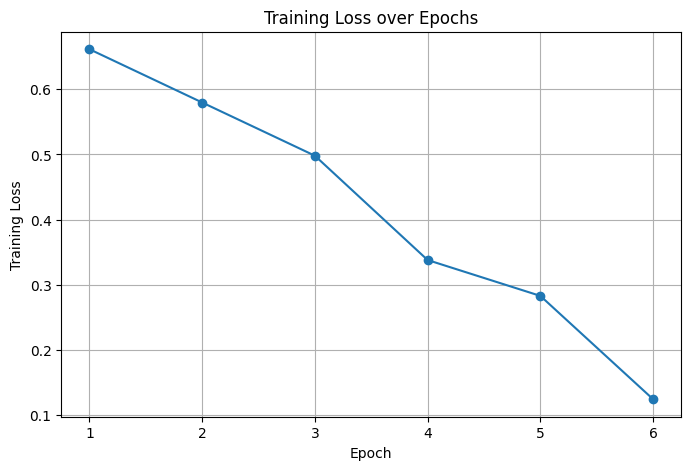

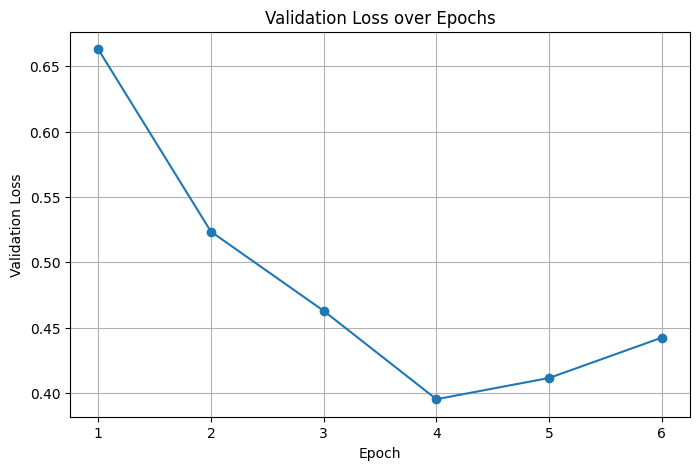

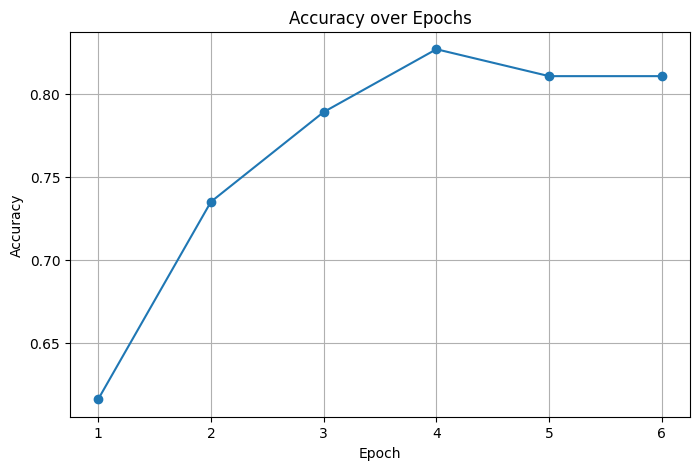

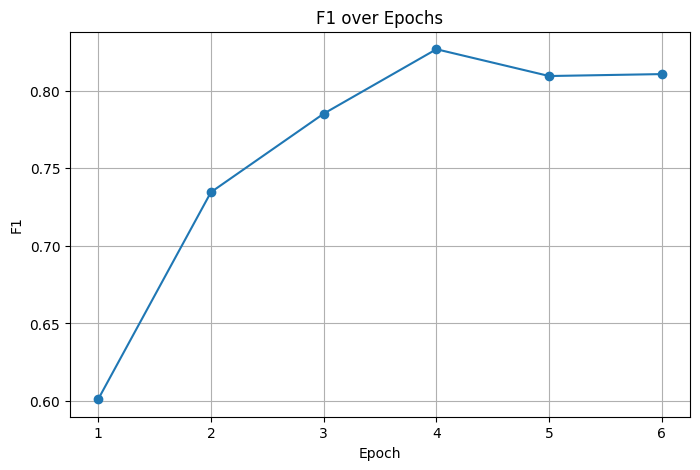

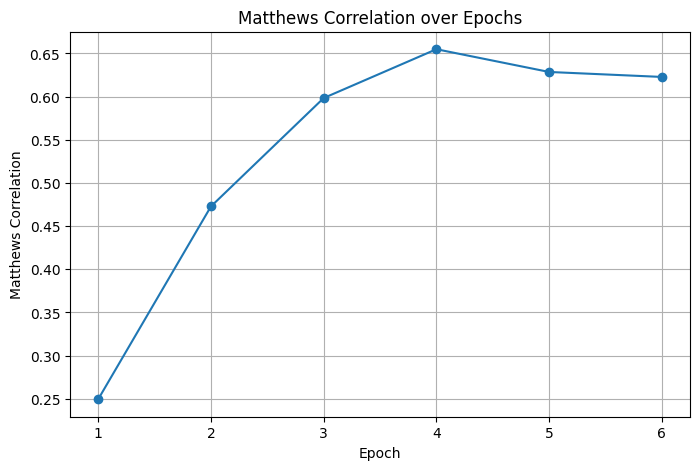

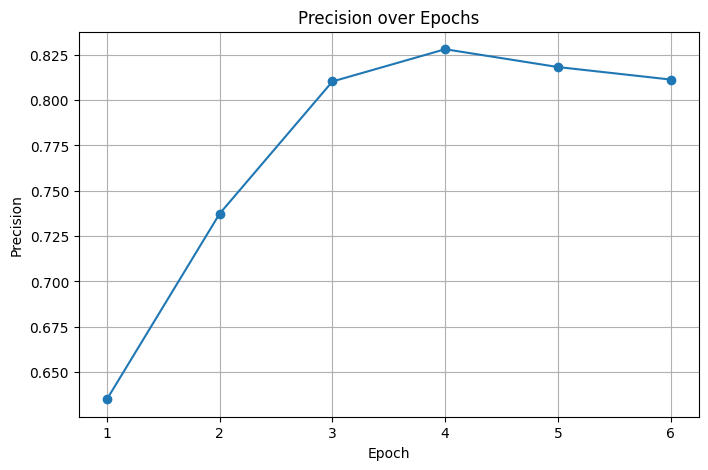

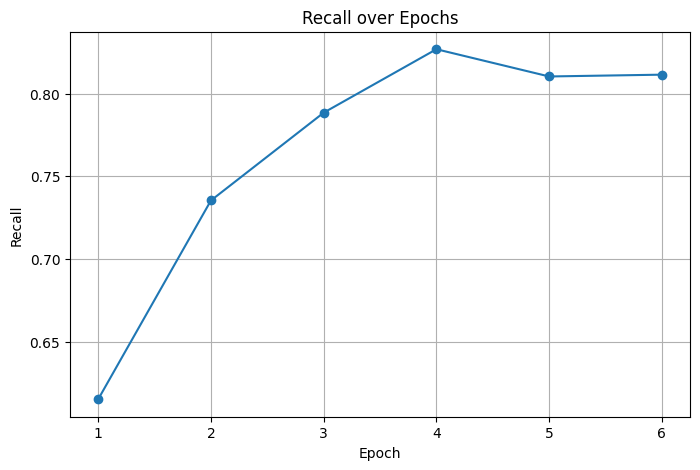

In [28]:
import pandas as pd
import io
import matplotlib.pyplot as plt

# The training progress data provided by the user
data = """Epoch   Training Loss   Validation Loss Accuracy        F1      Matthews Correlation    Precision       Recall
1       0.661700        0.663121        0.616216        0.601111        0.249465        0.635074        0.615182
2       0.579800        0.523527        0.735135        0.734639        0.472774        0.737388        0.735390
3       0.498000        0.462876        0.789189        0.785268        0.598324        0.810238        0.788482
4       0.337700        0.395240        0.827027        0.826845        0.654901        0.828026        0.826876
5       0.282600        0.411506        0.810811        0.809559        0.628554        0.818206        0.810396
6       0.123800        0.442371        0.810811        0.810805        0.622796        0.811307        0.811489
"""

# Read the data into a pandas DataFrame, skipping the header initially
df_progress = pd.read_csv(io.StringIO(data), sep='\s+', header=None, skiprows=1, engine='python')

# Manually assign the correct column names
df_progress.columns = ['Epoch', 'Training Loss', 'Validation Loss', 'Accuracy', 'F1', 'Matthews Correlation', 'Precision', 'Recall']


# Plotting each metric over epochs
metrics_to_plot = ['Training Loss', 'Validation Loss', 'Accuracy', 'F1', 'Matthews Correlation', 'Precision', 'Recall']

for metric in metrics_to_plot:
    plt.figure(figsize=(8, 5))
    plt.plot(df_progress['Epoch'], df_progress[metric], marker='o')
    plt.title(f'{metric} over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.grid(True)
    plt.show()

In [29]:
def classify_coding_sequences(sequence):

  # Check if there is input
  if not isinstance(sequence, str) or not sequence:
    return "Invalid input: Please provide a non-empty DNA sequence."

  # Check if length of input is valid
  if len(sequence) > tokenizer.model_max_length:
    return f'Input sequence is too long. Maximum length is {tokenizer.model_max_length}.'


  # Tokenize the input seq
  inputs = tokenizer(sequence, return_tensors='pt', padding=True, truncation=True)


  if 'token_type_ids' in inputs:
    del inputs['token_type_ids']


  # Make sure variables correspond to the device
  device = model.device
  inputs = {key: value.to(device) for key, value in inputs.items()}

  # Use the model to make a prediction
  with torch.no_grad():
    outputs = model(**inputs)

  # Get the output score from the model and use the highest class score
  logits = outputs.logits
  predicted_class_id = torch.argmax(logits, dim=1).item()


  class_labels = ['receptor', 'kinase']
  if predicted_class_id < len(class_labels):
    return class_labels[predicted_class_id]
  else:
    return f'Unknown class ID: {predicted_class_id}'


In [30]:
classify_coding_sequences('GTCAGAATGGCGGCAGCGGAGCATCGTCATTCTTCAGGATTGCCCTGCTGGCCCTACCTCACAGCTGAAGCTTTAAAAAACAGGATGGGCCGCCAGCCACCTCCTCCAACTCAACAACATTCTATAACTGATAACTCCCTGAGCCTCAAGACACCTCCCGAATGTCTCCTTCATCCCCTTCCACCCTCAGTGGATGATAATATCAAGGAGTGTCCTCTTGCTCCTCTTCCACCCTCAGTGGATGATAATCTGAAGGAGTATCTCCTGG')

'receptor'

In [ ]:
#@title Convert ipynb to HTML in Colab
# Upload ipynb
from google.colab import files
f = files.upload()

# Convert ipynb to html
import subprocess
file0 = list(f.keys())[0]
_ = subprocess.run(["pip", "install", "nbconvert"])
_ = subprocess.run(["jupyter", "nbconvert", file0, "--to", "html"])

# download the html
files.download(file0[:-5]+"html")